In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [18]:
df = pd.read_excel('DatosCacao_multivariado.xlsx')
df = df.fillna(method='ffill').dropna()
print(df.head())

       Fecha   COP/kg      TRM  COP/kg (internacional)  Inflacion  \
1 2024-01-08  14223.3  3912.93                16092.12       8.35   
2 2024-01-15  14086.3  3901.38                17102.48       8.35   
3 2024-01-22  14329.2  3916.39                17909.81       8.35   
4 2024-01-29  14530.8  3925.26                18449.86       8.35   
5 2024-02-05  14765.8  3928.11                20111.73       7.74   

   COP/kg (futuro)   Produccion  
1         15859.11  6995.448155  
2         16854.62  6995.448155  
3         17707.29  6995.448155  
4         18378.07  6995.448155  
5         19995.38  5082.187534  


C:\Users\peter\AppData\Local\Temp\ipykernel_16356\953973482.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').dropna()


In [19]:
# 2. Escalar datos para mejorar la convergencia de la red
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.drop(columns=['Fecha']))

# 3. Función para crear secuencias de ventana (timesteps)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :])  # ventana completa con variables (incluyendo exógenas)
        y.append(data[i+n_steps, 0])   # precio objetivo (col 0)
    return np.array(X), np.array(y)

timesteps = 10  # ventanas de semanas
X, y = create_sequences(data_scaled, timesteps)

# 4. Dividir 80/20 para entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
# 5. Construir modelo LSTM simple
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=(timesteps, X.shape[2])))
model.add(Dense(1))  # salida única
model.compile(optimizer='adam', loss='mse')

# 6. Entrenar modelo
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - loss: 0.3951 - val_loss: 0.1945
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2637 - val_loss: 0.1031
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1557 - val_loss: 0.0335
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0647 - val_loss: 0.0083
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0272 - val_loss: 0.0518
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0656 - val_loss: 0.0647
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0658 - val_loss: 0.0336
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0396 - val_loss: 0.0117
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0229 - val_loss: 0.0067
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0236 - val_loss: 0.0080
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0280 - val_loss: 0.0097
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0303 - va

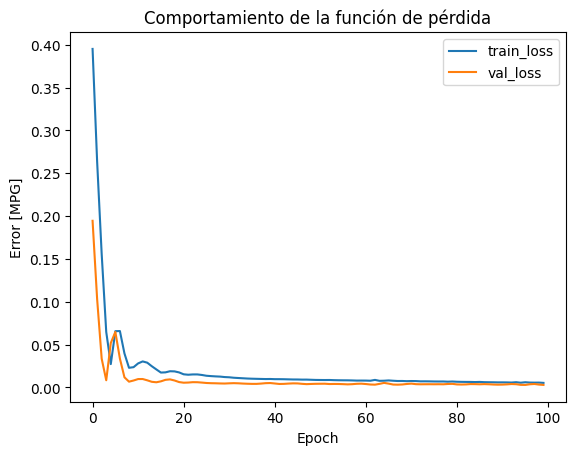

In [21]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.title("Comportamiento de la función de pérdida")
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
RMSE en test (original scale): 1199.16


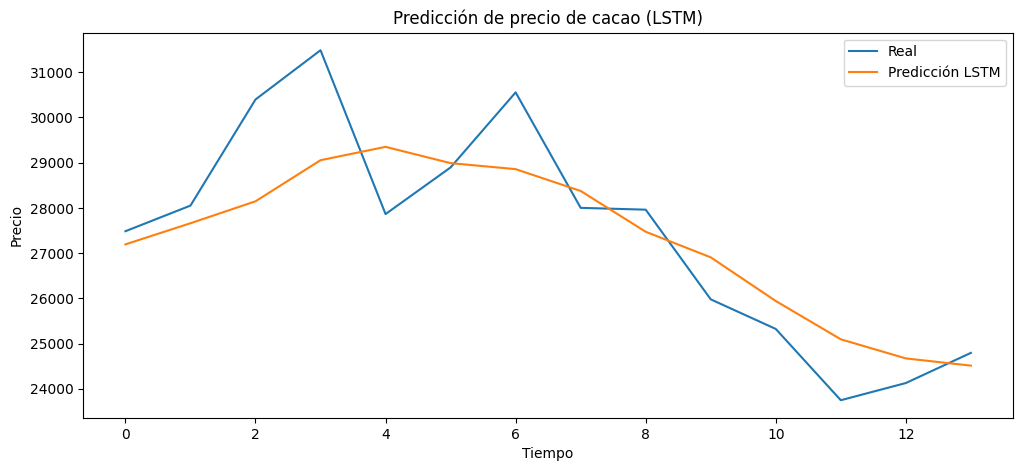

In [22]:
# 7. Predecir y rescatar datos escala original
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(np.hstack([y_test.reshape(-1,1), X_test[:,0,1:]]))[:,0]
y_pred_rescaled = scaler.inverse_transform(np.hstack([y_pred, X_test[:,0,1:]]))[:,0]

# 8. Calcular RMSE en escala original
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'RMSE en test (original scale): {rmse:.2f}')

# 9. Graficar
plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled, label='Real')
plt.plot(y_pred_rescaled, label='Predicción LSTM')
plt.legend()
plt.title('Predicción de precio de cacao (LSTM)')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.show()